# Answering Business Questions using SQL

У цьому проекті я збираюся використовувати базу даних Chinook. Chinook надається як файл бази даних SQLite під назвою chinook.db.

## Створення допоміжних функцій 

In [8]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

- run_query() приймає SQL-запит як аргумент і повертає DataFrame цього запиту.
- run_command() приймає команду SQL як аргумент і виконує її за допомогою модуля sqlite.
- show_tables() викликає функцію run_query(), щоб повернути список усіх таблиць і представлень у базі даних.

In [9]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''SELECT name,
           type
    FROM sqlite_master
    WHERE type IN ("table","view");'''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Вибір альбомів для придбання

Необхідно написати запит, щоб дізнатися, треки яких жанрів краще продаються у США, а потім створити візуалізацію цих даних за допомогою pandas.

In [10]:
q = '''
    WITH genre_track AS
    (
    SELECT t.genre_id,t.track_id, g.name
    FROM track t
    INNER JOIN genre g ON g.genre_id = t.genre_id
    ),
    sold AS
    (
    SELECT ge.name, i.track_id, billing_country
    FROM invoice_line i
    INNER JOIN genre_track ge ON ge.track_id = i.track_id
    INNER JOIN invoice inv ON inv.invoice_id = i.invoice_id
    )
    
    SELECT name genre,
           COUNT(track_id) tracks_sold,
           CAST(COUNT(track_id) AS FLOAT) / (SELECT COUNT(*)
                              FROM sold
                              WHERE billing_country = 'USA') percentages
    FROM sold
    WHERE billing_country = 'USA'
    GROUP BY genre
    ORDER BY tracks_sold DESC
    LIMIT 10;
    
'''
run_query(q)

,genre,tracks_sold,percentages
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


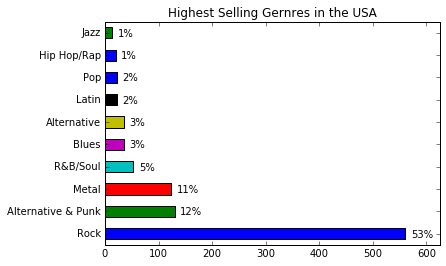

In [11]:
genre_sales_usa = run_query(q)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Highest Selling Gernres in the USA",
    xlim=(0,625)
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentages"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))
    
plt.show()

Графік вище містить жанри та кількість треків, проданих у США (як у абсолютних цифрах, так і у відсотках). Рок має найбільшу кількість продажів -  561, а джаз має 14 продажів, що є найнижчим показником.

Виходячи з представлених даних,  рекомендовано створювати треки у трьох наступних жанрах: Rock, Alternative & Punk, Metal.


## Аналіз ефективності продажів серед працівників

Кожен клієнт магазину Chinook призначається до агента підтримки продажів у компанії, коли вони вперше роблять покупку. Необхідно проаналізувати кількість покупок клієнів кожного співробітника, задля отримання інформації щодо ефективності роботи.


In [12]:
employee_sales_performance = '''
WITH cus_total AS
(
SELECT c.customer_id, SUM(total) total, c.support_rep_id
FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY c.customer_id
)
SELECT first_name || ' ' || last_name name ,SUM(cus.total) total
FROM employee e
INNER JOIN cus_total cus ON cus.support_rep_id = e.employee_id
GROUP BY employee_id
ORDER BY total DESC;

'''


run_query(employee_sales_performance)

,name,total
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


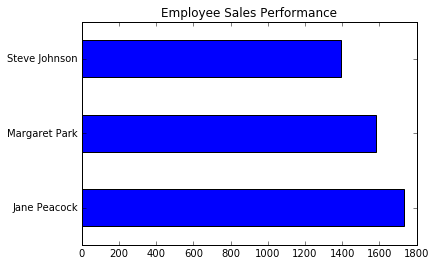

In [13]:
employee_performance = run_query(employee_sales_performance)
employee_performance.set_index('name', drop=True, inplace=True)
employee_performance.plot.barh(title = 'Employee Sales Performance', legend = False)
plt.ylabel('')
plt.show()

Джейн є найефективнішим робітником, на другому місці - Маргарет, на третьому - Стів.

## Аналіз продажів по країнам

Необхідно створити запит, який збирає дані про покупки з різних країн. Якщо країна має лише одного клієнта, вона має бути у групі «Other». Результати будуть відсортовані за загальним обсягом продажів від найвищого до найнижчого, з групою «Інші» в самому низу.

Для кожної країни я включаю:

- загальна кількість клієнтів;

- загальна вартість продажів;

- середнє значення продажів на одного клієнта;

- середня вартість замовлення.


In [14]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


Найбільший прибуток приносять наступні країни:

- USA

- Canada

- Brazil



## Альбоми vs окремі композиції 

Необхідно з’ясувати, який відсоток покупок складали окремі композиції порівняно з цілими альбомами.

In [29]:
album_or_not = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;

'''

run_query(album_or_not)

,album_purchase,percent
0,no,0.814332
1,yes,0.185668


Частка покупок окремих композицій серед усіх - 18.5%.